In [1]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

from matplotlib_venn import venn2_unweighted, venn2, venn3

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

# intersection of mutations in primary tumor and the liver metastasis

In [2]:
pwd

'/n/fs/ragr-data/users/palash/mskcc-analysis'

In [6]:
df_primary = pd.read_csv('data_old_panel1//primary_pos_indices.csv', sep=',')
df_liver_met = pd.read_csv('data_old_panel1//liver_met_pos_indices.csv', sep=',')
df_e1 = pd.read_csv('data_old_panel1//E1_pos_indices.csv', sep=',')

In [7]:
# df_primary = pd.read_csv('data/primary_selected_pos_indices.csv', sep=',')
# df_liver_met = pd.read_csv('data/liver_met_selected_pos_indices.csv', sep=',')
# df_e1 = pd.read_csv('data/E1_selected_pos_indices.csv', sep=',')

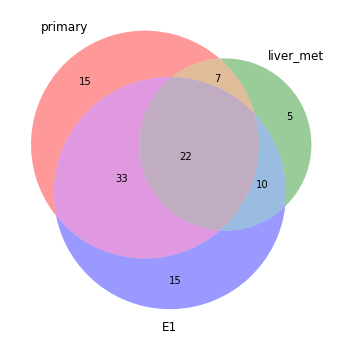

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
venn3([set(df_primary['pos']), set(df_liver_met['pos']), set(df_e1['pos'])], set_labels=('primary', 'liver_met', 'E1'))
fig.patch.set_facecolor('white')
# plt.savefig('figures/patient2_snv_venn_diagram_new.pdf', bbox_inches='tight')

In [8]:
# fig, ax = plt.subplots(1,1,figsize=(6,6))
# venn3([set(df_primary['pos']), set(df_liver_met['pos']), set(df_e1['pos'])], set_labels=('primary', 'liver_met', 'E1'))
# plt.savefig('figures/patient2_snv_venn_diagram.pdf', bbox_inches='tight')

In [9]:
df_primary

,index,pos,chrom,amplicon,ref,alt,gene
0,5727,347184,16,AMPL87363,A,G,AXIN1
1,2556,7229346,6,AMPL87293,T,C,RREB1
2,2591,7229619,6,AMPL87294,G,A,RREB1_1
3,6013,7572865,17,AMPL40059,A,C,EIF4A1
4,6014,7572865,17,AMPL40059,A,T,EIF4A1_1
...,...,...,...,...,...,...,...
100,1746,169998036,3,AMPL70415,G,A,1746
101,1747,169998037,3,AMPL70415,G,A,1747
102,15190,169998033,3,AMPL70415,A,G,15190
103,15192,169998035,3,AMPL70415,T,C,15192


In [10]:
df_liver_met

,index,pos,chrom,amplicon,ref,alt,gene
0,7466,347184,16,AMPL87363,A,G,AXIN1
1,3151,7229346,6,AMPL87293,T,C,RREB1
2,7907,7572865,17,AMPL40059,A,C,EIF4A1
3,7908,7572865,17,AMPL40059,A,G,EIF4A1_1
4,7911,7572870,17,AMPL40059,A,T,EIF4A1_2
...,...,...,...,...,...,...,...
60,24741,151884280,7,AMPL87311,A,T,24741
61,4411,151962055,7,AMPL87312,C,T,GALNTL5
62,4415,151962062,7,AMPL87312,A,G,GALNTL5_1
63,4416,151962068,7,AMPL87312,T,C,GALNTL5_2


In [14]:
set(df_liver_met.pos).intersection(set(df_primary.pos)) - set(df_liver_met.pos).intersection(set(df_primary.pos).intersection(set(df_e1.pos)))

{10270747, 47039734, 151962055, 151962062, 151962068}

In [15]:
positions_of_interest = {10270747, 47039734, 151962055, 151962062, 151962068}

In [17]:
df_liver_met[df_liver_met.pos.isin(positions_of_interest)]

,index,pos,chrom,amplicon,ref,alt,gene
12,9677,10270747,19,AMPL70499,A,*,9677
13,9678,10270747,19,AMPL70499,A,G,9678
24,10534,47039734,X,AMPL87417,C,G,JADE3_2
61,4411,151962055,7,AMPL87312,C,T,GALNTL5
62,4415,151962062,7,AMPL87312,A,G,GALNTL5_1
63,4416,151962068,7,AMPL87312,T,C,GALNTL5_2


In [18]:
df_primary[df_primary.pos.isin(positions_of_interest)]

,index,pos,chrom,amplicon,ref,alt,gene
36,7556,10270747,19,AMPL70499,A,*,7556
37,7557,10270747,19,AMPL70499,A,G,7557
55,8190,47039734,X,AMPL87417,C,G,JADE3_2
94,3458,151962055,7,AMPL87312,C,T,GALNTL5
95,3461,151962062,7,AMPL87312,A,G,GALNTL5_1
96,3462,151962068,7,AMPL87312,T,C,GALNTL5_2


In [19]:
df_e1[df_e1.pos.isin(positions_of_interest)]

,index,pos,chrom,amplicon,ref,alt,gene


In [21]:
len(df_liver_met)

65

In [22]:
len(df_e1)

126

In [23]:
len(df_primary)

105

# panel2

In [9]:
loomfile_dict = {'primary1': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_32_1_IGO_12742_B_2/results/RA17_22_32_1_IGO_12742_B_2.cells.loom',
                 'primary2': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_35_1_IGO_12742_2/results/RA17_22_35_1_IGO_12742_2.cells.loom',
                 'liver_met': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_39_6_IGO_12742_1/results/RA17_22_39_6_IGO_12742_1.cells.loom',
                 'lung_met': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_06_2_IGO_12742_C_2/results/RA17_22_06_2_IGO_12742_C_2.cells.loom',
                 'retro_met': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_42_2_IGO_12742_C_1/results/RA17_22_42_2_IGO_12742_C_1.cells.loom',
                 'peri_met': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/transfer/RA17_22_panel2/pipeline_results_default/RA17_22/RA17_22_27_2_IGO_12742_B_1/results/RA17_22_27_2_IGO_12742_B_1.cells.loom'}

In [16]:
sample_list = list(loomfile_dict.keys())

In [15]:
data_dir = 'data'
overview_data = []
for sample, loom_name in loomfile_dict.items():
    print('-'*50, sample, '-'*50, sep=' ')
    with loompy.connect(loom_name) as ds:
        print(f"number of covered positions is {ds.shape[0]}")
        print(f"number of cells is {ds.shape[1]}")
        print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
        print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")
        # ncells = ds.shape[1]
    
    # df_pos = pd.read_csv(f'{data_dir}/{sample}_pos_indices.csv')
    # break

-------------------------------------------------- primary1 --------------------------------------------------
number of covered positions is 188363
number of cells is 1810
number of amplicons is 596
number of chromosomes is 23
-------------------------------------------------- primary2 --------------------------------------------------
number of covered positions is 182548
number of cells is 1955
number of amplicons is 596
number of chromosomes is 23
-------------------------------------------------- liver_met --------------------------------------------------
number of covered positions is 170766
number of cells is 1137
number of amplicons is 596
number of chromosomes is 23
-------------------------------------------------- lung_met --------------------------------------------------
number of covered positions is 177987
number of cells is 2075
number of amplicons is 596
number of chromosomes is 23
-------------------------------------------------- retro_met --------------------------

## SNVs in two samples from the primary tumor

-------------------------------------------------- data --------------------------------------------------
-------------------------------------------------- data_set1 --------------------------------------------------
-------------------------------------------------- data_set2 --------------------------------------------------


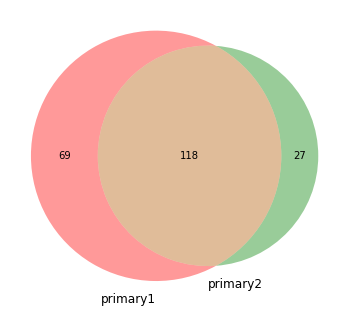

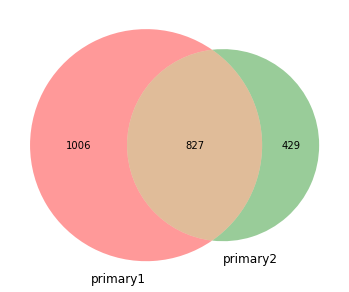

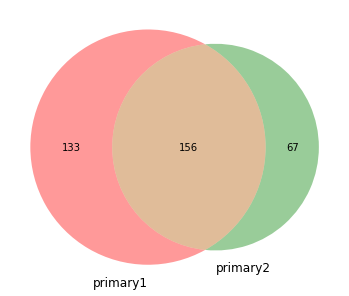

In [19]:
for data_dir in ['data', 'data_set1', 'data_set2']:
    print('-'*50, data_dir, '-'*50, sep=' ')
    df_pos1 =  pd.read_csv(f'{data_dir}/primary1_pos_indices.csv')
    df_pos2 =  pd.read_csv(f'{data_dir}/primary2_pos_indices.csv')

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    venn2([set(df_pos1['pos']), set(df_pos2['pos'])], set_labels=('primary1', 'primary2'))
    fig.patch.set_facecolor('white')